In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.visualization.scatter import Scatter

In [2]:
start_date = '2022-01-01'
end_date = '2023-12-31'
initial_value = 100000

adj_close_df = pd.read_csv('relatorios/preco-ativos.csv', index_col=0, parse_dates=True)

rebalance_dates = pd.DatetimeIndex(pd.read_csv('relatorios/datas-fim-de-mes.txt', header=None)[0])
rebalance_dates = rebalance_dates[(rebalance_dates>=start_date) & (rebalance_dates <= end_date)]

rebalance_dates

portfolio_value = initial_value
portfolio_values = []
dates = []
weights_history = []

In [3]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, **kwargs):
        super().__init__(n_var=len(mu), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
    def _evaluate(self, x, out, *args, **kwargs):
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

class SumToOneRepair(Repair):
    def _do(self, problem, X, **kwargs):
        return X / np.sum(X, axis=1, keepdims=True)

In [4]:
returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

mu = returns.mean() * 252
cov = returns.cov() * 252

problem = PortfolioProblem(mu, cov)
algorithm = NSGA2(pop_size=200, repair=SumToOneRepair())
termination = get_termination("n_gen", 500)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      9 |             - |             -
     2 |      400 |     15 |  0.2015240586 |         ideal
     3 |      600 |     24 |  0.1118523535 |         ideal
     4 |      800 |     17 |  0.0691573633 |         ideal
     5 |     1000 |     16 |  0.1323282991 |         ideal
     6 |     1200 |     13 |  0.1074973732 |         ideal
     7 |     1400 |     26 |  0.0600502445 |         ideal
     8 |     1600 |     34 |  0.0998971542 |         ideal
     9 |     1800 |     31 |  0.1180191905 |         ideal
    10 |     2000 |     25 |  0.0306947312 |         ideal
    11 |     2200 |     25 |  0.0134896147 |         ideal
    12 |     2400 |     30 |  0.0155592194 |             f
    13 |     2600 |     36 |  0.0593300176 |         ideal
    14 |     2800 |     40 |  0.0553036188 |         ideal
    15 |     3000 |     50 |  0.0126352046 |         ideal
    16 |     3200 |     43 |  0.0334074650 |         ide

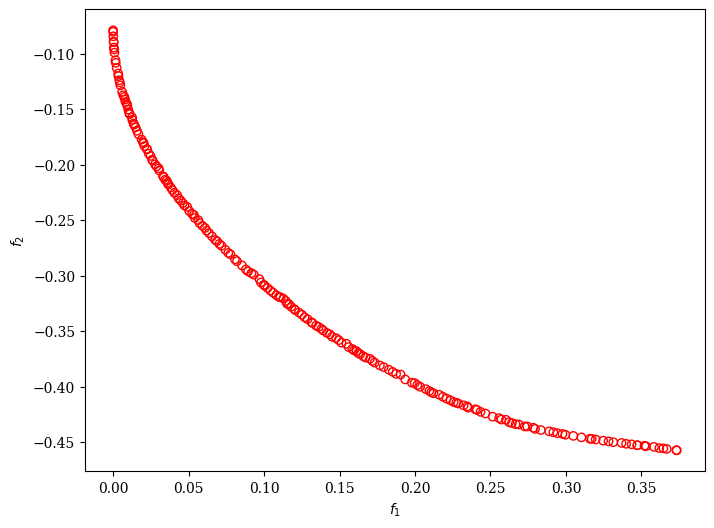

In [5]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

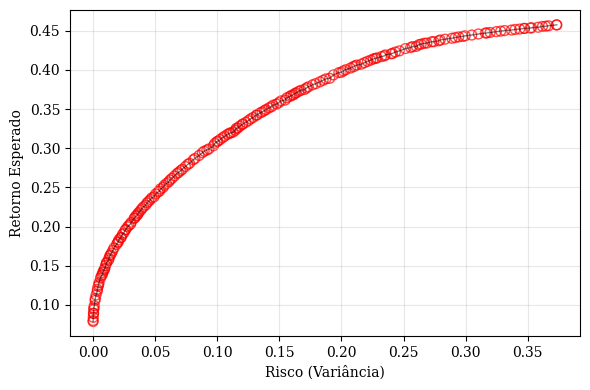

In [22]:
import matplotlib.pyplot as plt

# Transformar os dados
risk = res.F[:, 0]
expected_return = -res.F[:, 1]  # Multiplicar por -1 para obter retorno positivo

# Criar o plot personalizado
plt.figure(figsize=(6, 4))
plt.scatter(risk, expected_return, facecolor="none", edgecolor="red", s=50, alpha=0.7)

# Personalizar labels e título
plt.xlabel('Risco (Variância)')
plt.ylabel('Retorno Esperado')
plt.grid(True, alpha=0.3)

# Destacar a fronteira eficiente
sorted_indices = np.argsort(risk)
plt.plot(risk[sorted_indices], expected_return[sorted_indices], 'k-', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Transformar dados
risk = res.F[:, 0]
expected_return = -res.F[:, 1]

# Calcular Sharpe ratio
risk_free_rate = 0.1067 + 0.04  # 2% ao ano
sharpe_ratios = (expected_return - risk_free_rate) / np.sqrt(risk)

# Selecionar os 3 portfólios
max_return_idx = np.argmax(expected_return)  # Maior retorno
min_risk_idx = np.argmin(risk)               # Menor risco
max_sharpe_idx = np.argmax(sharpe_ratios)    # Maior Sharpe

# Função para mostrar composição do portfólio
def show_portfolio_composition(weights, title, idx):
    tickers = adj_close_df.columns.tolist()
    
    print(f"\n{title}")
    print("=" * 50)
    print(f"Retorno esperado: {expected_return[idx]:.2%}")
    print(f"Risco (volatilidade): {np.sqrt(risk[idx]):.2%}")
    print(f"Sharpe ratio: {sharpe_ratios[idx]:.3f}")
    print("\nComposição do portfólio:")
    
    # Criar lista de (ticker, peso) e ordenar por peso
    portfolio_composition = [(ticker, weight) for ticker, weight in zip(tickers, weights)]
    portfolio_composition.sort(key=lambda x: x[1], reverse=True)
    
    # Mostrar apenas ativos com peso > 0.5%
    significant_assets = [(ticker, weight) for ticker, weight in portfolio_composition if weight > 0.005]
    
    for ticker, weight in significant_assets:
        print(f"  {ticker}: {weight:.2%}")
    
    total_significant = sum(weight for _, weight in significant_assets)
    print(f"\nTotal dos ativos significativos: {total_significant:.2%}")
    
    return significant_assets

# Analisar os 3 portfólios
print("ANÁLISE DOS PORTFÓLIOS SELECIONADOS")
print("=" * 60)

portfolio1 = show_portfolio_composition(res.X[max_return_idx], "PORTFÓLIO DE MAIOR RETORNO", max_return_idx)
portfolio2 = show_portfolio_composition(res.X[min_risk_idx], "PORTFÓLIO DE MENOR RISCO", min_risk_idx)
portfolio3 = show_portfolio_composition(res.X[max_sharpe_idx], "PORTFÓLIO DE MAIOR SHARPE RATIO", max_sharpe_idx)

ANÁLISE DOS PORTFÓLIOS SELECIONADOS

PORTFÓLIO DE MAIOR RETORNO
Retorno esperado: 45.74%
Risco (volatilidade): 61.11%
Sharpe ratio: 0.509

Composição do portfólio:
  PRIO3: 99.84%

Total dos ativos significativos: 99.84%

PORTFÓLIO DE MENOR RISCO
Retorno esperado: 7.89%
Risco (volatilidade): 0.32%
Sharpe ratio: -21.046

Composição do portfólio:
  IMA-S: 94.46%
  IRFM-1: 5.16%

Total dos ativos significativos: 99.62%

PORTFÓLIO DE MAIOR SHARPE RATIO
Retorno esperado: 40.51%
Risco (volatilidade): 45.91%
Sharpe ratio: 0.563

Composição do portfólio:
  PRIO3: 58.80%
  BTC: 27.82%
  BPAC11: 13.03%

Total dos ativos significativos: 99.64%


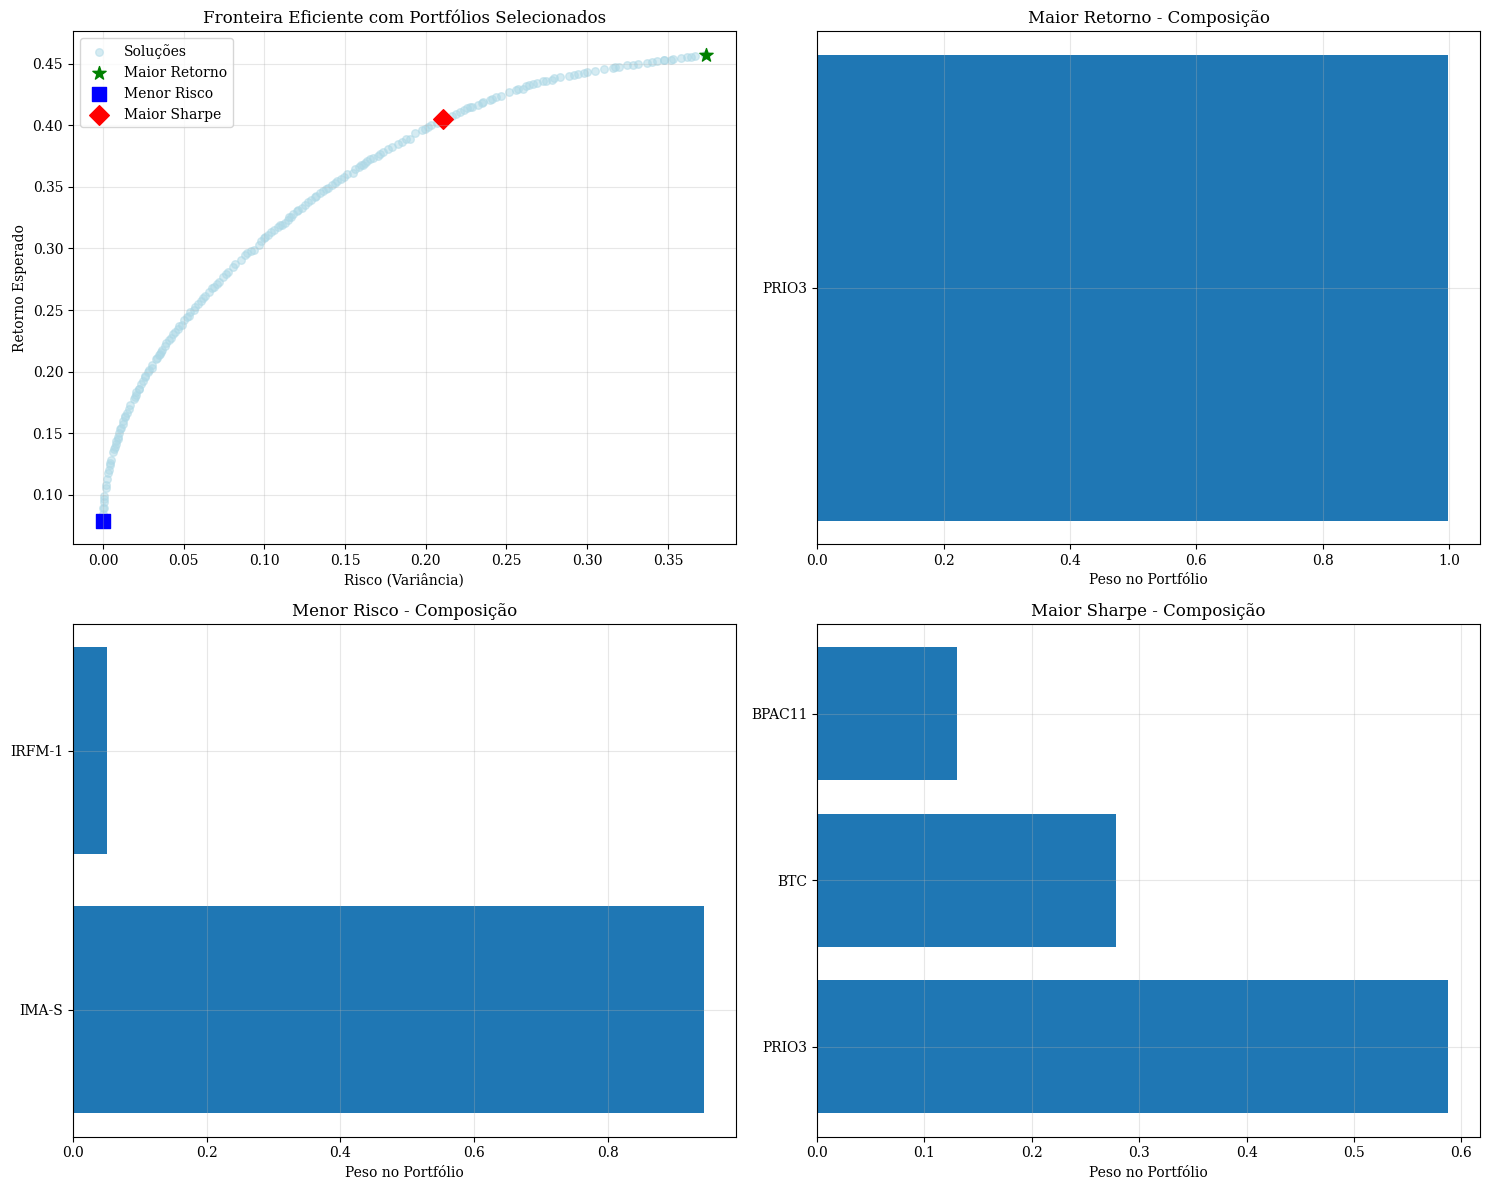

In [8]:
# Visualização comparativa
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Fronteira eficiente com os 3 portfólios destacados
ax1.scatter(risk, expected_return, alpha=0.5, s=30, color='lightblue', label='Soluções')
ax1.scatter(risk[max_return_idx], expected_return[max_return_idx], 
           color='green', s=100, marker='*', label='Maior Retorno')
ax1.scatter(risk[min_risk_idx], expected_return[min_risk_idx], 
           color='blue', s=100, marker='s', label='Menor Risco')
ax1.scatter(risk[max_sharpe_idx], expected_return[max_sharpe_idx], 
           color='red', s=100, marker='D', label='Maior Sharpe')

ax1.set_xlabel('Risco (Variância)')
ax1.set_ylabel('Retorno Esperado')
ax1.set_title('Fronteira Eficiente com Portfólios Selecionados')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Composição do portfólio de maior retorno
if portfolio1:
    tickers1, weights1 = zip(*portfolio1[:10])  # Top 10
    ax2.barh(range(len(tickers1)), weights1)
    ax2.set_yticks(range(len(tickers1)))
    ax2.set_yticklabels(tickers1)
    ax2.set_xlabel('Peso no Portfólio')
    ax2.set_title('Maior Retorno - Composição')
    ax2.grid(True, alpha=0.3)

# Plot 3: Composição do portfólio de menor risco
if portfolio2:
    tickers2, weights2 = zip(*portfolio2[:10])  # Top 10
    ax3.barh(range(len(tickers2)), weights2)
    ax3.set_yticks(range(len(tickers2)))
    ax3.set_yticklabels(tickers2)
    ax3.set_xlabel('Peso no Portfólio')
    ax3.set_title('Menor Risco - Composição')
    ax3.grid(True, alpha=0.3)

# Plot 4: Composição do portfólio de maior Sharpe
if portfolio3:
    tickers3, weights3 = zip(*portfolio3[:10])  # Top 10
    ax4.barh(range(len(tickers3)), weights3)
    ax4.set_yticks(range(len(tickers3)))
    ax4.set_yticklabels(tickers3)
    ax4.set_xlabel('Peso no Portfólio')
    ax4.set_title('Maior Sharpe - Composição')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Tabela comparativa resumida
import pandas as pd

comparison_data = {
    'Métrica': ['Retorno Esperado', 'Risco (Volatilidade)', 'Sharpe Ratio'],
    'Maior Retorno': [
        f"{expected_return[max_return_idx]:.2%}",
        f"{np.sqrt(risk[max_return_idx]):.2%}",
        f"{sharpe_ratios[max_return_idx]:.3f}"
    ],
    'Menor Risco': [
        f"{expected_return[min_risk_idx]:.2%}",
        f"{np.sqrt(risk[min_risk_idx]):.2%}",
        f"{sharpe_ratios[min_risk_idx]:.3f}"
    ],
    'Maior Sharpe': [
        f"{expected_return[max_sharpe_idx]:.2%}",
        f"{np.sqrt(risk[max_sharpe_idx]):.2%}",
        f"{sharpe_ratios[max_sharpe_idx]:.3f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nTABELA COMPARATIVA DOS PORTFÓLIOS")
print("=" * 60)
print(comparison_df.to_string(index=False))


TABELA COMPARATIVA DOS PORTFÓLIOS
             Métrica Maior Retorno Menor Risco Maior Sharpe
    Retorno Esperado        45.74%       7.89%       40.51%
Risco (Volatilidade)        61.11%       0.32%       45.91%
        Sharpe Ratio         0.509     -21.046        0.563


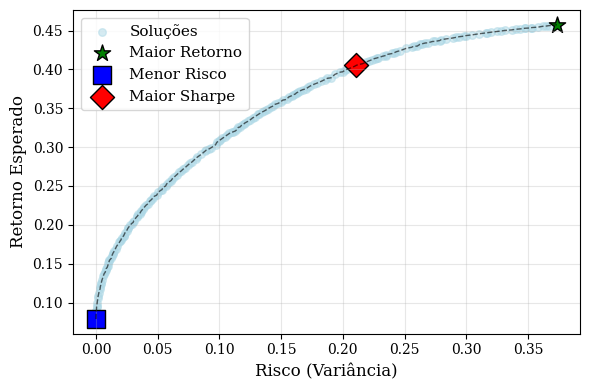

In [19]:
# Plot da fronteira eficiente com os 3 portfólios destacados
plt.figure(figsize=(6, 4))

# Scatter plot de todas as soluções
plt.scatter(risk, expected_return, alpha=0.5, s=30, color='lightblue', label='Soluções')

# Destacar os 3 portfólios selecionados
plt.scatter(risk[max_return_idx], expected_return[max_return_idx], 
           color='green', s=150, marker='*', label='Maior Retorno', edgecolors='black', linewidth=1)
plt.scatter(risk[min_risk_idx], expected_return[min_risk_idx], 
           color='blue', s=150, marker='s', label='Menor Risco', edgecolors='black', linewidth=1)
plt.scatter(risk[max_sharpe_idx], expected_return[max_sharpe_idx], 
           color='red', s=150, marker='D', label='Maior Sharpe', edgecolors='black', linewidth=1)

# Personalização do gráfico
plt.xlabel('Risco (Variância)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Adicionar linha da fronteira eficiente
sorted_indices = np.argsort(risk)
plt.plot(risk[sorted_indices], expected_return[sorted_indices], 'k--', alpha=0.6, linewidth=1, label='Fronteira')

plt.tight_layout()
plt.show()